# A 1-D example of Chemical Explosive Mode Analysis (CEMA) for $CH_4$ ignition

Let us implement an sample CEMA for methane combustion case.To do so we first generate the 1-D methane combustion data using Arrhenius.jl

In [2]:
using Arrhenius
using ForwardDiff
using DifferentialEquations
using LinearAlgebra
using Plots
using PyCall
ct = pyimport("cantera")

PyObject <module 'cantera' from '/usr/lib/python3/dist-packages/cantera/__init__.py'>

In [5]:
gas_ct = ct.Solution("gri30.xml")
gas = CreateSolution("../mechanism/gri30.yaml")

Arrhenius.Solution(53, 325, [2.016, 1.008, 15.999, 31.998, 17.007, 18.015, 33.006, 34.014, 12.011, 13.018999999999998  …  43.025, 43.025, 43.025, 42.016999999999996, 28.014, 39.95, 43.089, 44.097, 43.045, 44.053], ["H2", "H", "O", "O2", "OH", "H2O", "HO2", "H2O2", "C", "CH"  …  "HCNO", "HOCN", "HNCO", "NCO", "N2", "AR", "C3H7", "C3H8", "CH2CHO", "CH3CHO"], ["O", "H", "C", "N", "Ar"], [0.0 0.0 … 1.0 1.0; 2.0 1.0 … 3.0 4.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Arrhenius.IdealGasThermo([2.34433112 0.00798052075 … -917.935173 0.683010238; 2.5 7.05332819e-13 … 25473.6599 -0.446682853; … ; 3.409062 0.010738574 … 1521.4766 9.55829; 4.7294595 -0.0031932858 … -21572.878 4.1030159], [3.3372792 -4.94024731e-5 … -950.158922 -3.20502331; 2.50000001 -2.30842973e-11 … 25473.6599 -0.446682914; … ; 5.97567 0.008130591 … 490.3218 -5.045251; 5.4041108 0.011723059 … -22593.122 -3.4807917], [200.0 1000.0 3500.0; 200.0 1000.0 3500.0; … ; 300.0 1000.0 5000.0; 200.0 1000.0 6000.0], false), Arrhenius.Tra

In [6]:
ns = gas.n_species
print(ns);
nr = gas.n_reactions
print("\n",nr);

53
325

In [7]:
species_arr = gas.species_names

53-element Vector{String}:
 "H2"
 "H"
 "O"
 "O2"
 "OH"
 "H2O"
 "HO2"
 "H2O2"
 "C"
 "CH"
 "CH2"
 "CH2(S)"
 "CH3"
 ⋮
 "H2CN"
 "HCNN"
 "HCNO"
 "HOCN"
 "HNCO"
 "NCO"
 "N2"
 "AR"
 "C3H7"
 "C3H8"
 "CH2CHO"
 "CH3CHO"

In [17]:
#get equivalence ratio
gas_ct.TP = 900, ct.one_atm
phi = 1
gas_ct.set_equivalence_ratio(phi, "CH4","O2:1, N2:3.76")

In [21]:
specs = gas_ct.X
find(x->(x>0),specs)

LoadError: UndefVarError: find not defined

In [46]:
Y0 = zeros(ns)
Y0[species_index(gas, "CH4")] = 0.05
Y0[species_index(gas, "O2")] = 0.22
Y0[species_index(gas,"N2")] = 0.73
T0 = 1300  #K
P = one_atm
u0 = vcat(Y0, T0);

In [47]:
@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudt! (generic function with 1 method)

In [48]:
tspan = [0.0, 0.07];
prob = ODEProblem(dudt!, u0, tspan);
sol = solve(prob, TRBDF2(), reltol=1e-6, abstol=1e-9);
print(sol[end])

[0.0007372047769254919, 0.00015783813441258581, 0.0024684764564995667, 0.030240894023154722, 0.009514030316890703, 0.09925295177222965, 5.999200322512603e-6, 2.745199996984539e-7, 1.1655762192849003e-14, 1.1195793281653313e-15, 9.169500260625093e-16, 7.417468071139761e-17, 1.1526296348853825e-15, 1.6559665608689453e-16, 0.02639335196179212, 0.09569054288713183, 1.3926994094453778e-8, 1.1347285657166752e-10, 1.3074647243442918e-15, 2.6681749783590557e-17, 3.8453520809023416e-17, 5.6420499565209635e-21, 1.4785698813585826e-19, 3.2237756053507546e-24, 7.281778600979616e-25, 1.6873468039224525e-29, 3.6881881095716126e-31, 1.2623809037968665e-17, 4.2550975151592306e-18, 1.2943563840775742e-20, 3.8472657287692335e-7, 4.0801441084301696e-8, 7.14521858643824e-9, 4.924599456330184e-9, 1.0282015957786918e-8, 0.010380621594693025, 4.3757920969141466e-6, 8.035663360454821e-7, 3.6552718100736904e-7, 7.382181252022507e-12, 2.950729500815938e-10, 3.6453197064588955e-16, 4.785953872629456e-19, 8.23482

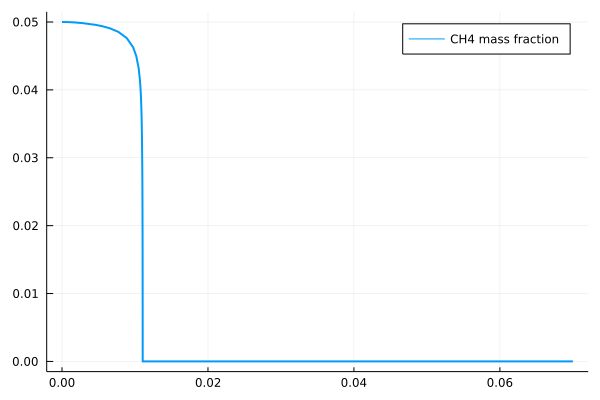

In [49]:
#plot stuff
plt1 = plot(sol.t, sol[species_index(gas, "CH4"), :], lw=2, label="CH4 mass fraction");
plot(plt1)

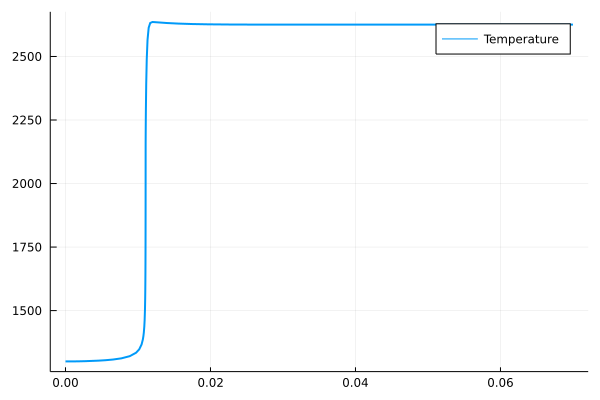

In [50]:
plt2 = plot(sol.t, sol[end,:],lw=2, label ="Temperature");
plot(plt2)

In [72]:
#compute the jacobian 
function dudt(u)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du = vcat(Ydot, Tdot)
end
@time J_w = ForwardDiff.jacobian(dudt,sol[end])

  0.230798 seconds (405.00 k allocations: 25.309 MiB, 16.89% gc time, 99.58% compilation time)


54×54 Matrix{Float64}:
    -1.52695e6         7.13195e6    …   21485.2               0.824522
     7.63502e5        -4.49871e6       -10742.5              -0.584406
    -3.05046e6         2.3922e7        -28991.5              -5.04239
 -5439.7              -1.94202e7        -1416.48             -3.77348
    -6.39097e6         4.54834e7           -2.15116e5        24.7637
     1.0205e7         -4.76365e7    …       2.60533e5       -15.4171
  5391.86          19308.6               1455.83              0.150413
   -36.2059        -1744.06                -6.56466           0.210893
    -4.62871e-6        0.000280186         -1.68825e-18       1.31532e-9
     8.09969e-7        5.60372e-5           5.85536e-12       1.36516e-10
     4.41289e-6        2.61133e-6   …       2.77507e-12       2.2412e-11
    -2.26432e-7        5.40157e-6          -1.70388e-10       9.57e-12
     2.85661e-7        1.08957e-5           3.11854e5         7.702e-12
     ⋮                              ⋱               

In [73]:
eig_vals = eigvals(J_w)

54-element Vector{Float64}:
      -5.1402940277116776e8
      -5.13152406186228e8
      -1.047488154189249e8
      -4.016960521435924e7
      -3.712423735420916e7
      -3.656225824242137e7
      -3.465295356192211e7
      -3.458235019079888e7
      -3.222971058255094e7
      -3.218474998638545e7
      -2.1424526246316772e7
      -1.6560164920316156e7
      -1.5350392042396849e7
       ⋮
 -376970.8910503711
 -263703.93432325067
 -159718.90651112387
 -123941.40921549303
   -6630.883336015616
    -304.2359055369181
      -3.951849578020171e-8
      -5.965913016854841e-9
      -1.1194473550679741e-10
       0.0
       2.555719020746241e-8
       1.1448487553316728e-7

In [78]:
#now extract all the positive eigen values: 
findall(x->(x > 0), eig_vals) 

2-element Vector{Int64}:
 53
 54

In [79]:
eigvecs(J_w)

54×54 Matrix{Float64}:
  2.70714e-8   -7.1509e-7    -2.51146e-6   …   3.68468e-6    2.64177e-6
  1.72087e-9    7.05283e-5    2.57949e-6       1.02975e-6    9.2112e-7
 -2.65337e-7   -7.3539e-6     3.41717e-6       9.43655e-6    1.23394e-5
  1.77707e-5    1.80682e-6   -3.41017e-5      -4.11591e-5    2.88098e-5
  0.000175692   9.22861e-6    8.56997e-5       2.33229e-5    2.75997e-5
 -0.000274375  -1.75474e-5   -8.70614e-5   …  -1.07149e-5   -3.82003e-5
 -0.000537388  -5.1194e-5    -4.49305e-7       7.61265e-9    1.7135e-8
  0.000618398   6.21162e-5   -2.38254e-8       3.1115e-10    5.47463e-10
  4.26755e-18  -4.03337e-17   6.37716e-7       2.2017e-16    2.0083e-16
 -8.61843e-18  -8.09984e-18  -1.97865e-5       2.15168e-17   1.88548e-17
 -6.28377e-19  -1.0581e-19    0.000285173  …   1.68573e-17   1.3881e-17
 -2.15674e-19  -1.08432e-18  -0.000372372      1.40081e-18   1.16429e-18
 -4.37923e-19  -2.01582e-18   7.11077e-5       1.87427e-17   1.41786e-17
  ⋮                                    

In [82]:
F = eigen(J_w)
Q = eigvecs(F) # right eigenvectors 
QL = inv(eigvecs(F)) # left eigenvectors 
Λ = Diagonal(eigvals(F))

54×54 Diagonal{Float64, Vector{Float64}}:
 -5.14029e8    ⋅           ⋅         …   ⋅    ⋅           ⋅ 
   ⋅         -5.13152e8    ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅         -1.04749e8      ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅         …   ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅         …   ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
  ⋮                                  ⋱                   
   ⋅           ⋅           ⋅             ⋅    ⋅           ⋅ 
   ⋅           ⋅           ⋅             ⋅    

In [86]:
EP = Diagonal(Q*QL)
sum(EP)

54.000000000000014

In [87]:
EI = Diagonal(Q*QL)/sum(EP)

54×54 Diagonal{Float64, Vector{Float64}}:
 0.0185185   ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅         0.0185185   ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅         0.0185185      ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
 ⋮                                ⋱                        
  ⋅          ⋅          ⋅             ⋅          ⋅          ⋅ 
  ⋅          ⋅  